In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import scipy
import scipy.sparse.linalg
import scipy.signal

In [2]:
def plot_subimages(images, size=(10, 10)):
    plt.figure(figsize=size)
    plt.subplot(221)
    plt.imshow(images[0])

    plt.subplot(222)
    plt.imshow(images[1])
    plt.show()

def plot_gray_subimages(images, size=(10, 10)):
    plt.figure(figsize=size)
    plt.subplot(221)
    plt.imshow(images[0], 'gray')

    plt.subplot(222)
    plt.imshow(images[1], 'gray')
    plt.show()

 You are solving for unknown intensity values inside the region R. Test the method in smooth regions and also in
regions with edges (high-frequency) (5 points). Also report the behavior as the size of the selected region
increases (5 points).

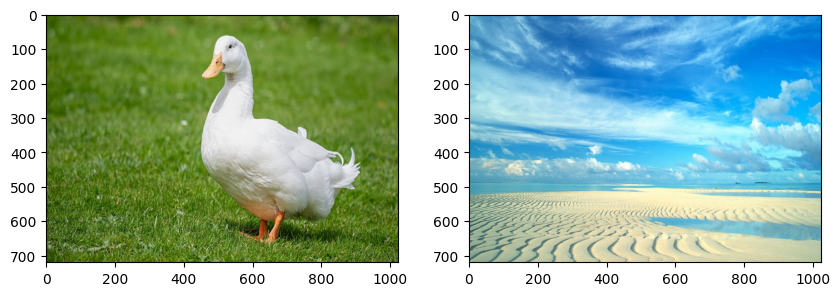

In [3]:
img_path = './data'
img_blue_sky = cv2.imread('./data/blue_sky.jpg')
img_rainbow = cv2.imread('./data/rainbow.jpg')
img_duck = cv2.imread('./data/duck.jpg')

# Convert BGR to RGB
img_blue_sky = cv2.cvtColor(img_blue_sky, cv2.COLOR_BGR2RGB)
img_rainbow = cv2.cvtColor(img_rainbow, cv2.COLOR_BGR2RGB)
img_duck = cv2.cvtColor(img_duck, cv2.COLOR_BGR2RGB)

# Resize images into a smaller resolution
IMG_SIZE = (1024, 720)
img_blue_sky = cv2.resize(img_blue_sky, IMG_SIZE)
img_duck = cv2.resize(img_duck, IMG_SIZE)
img_rainbow = cv2.resize(img_rainbow, IMG_SIZE)

# Show the images
plot_subimages([img_duck, img_blue_sky])

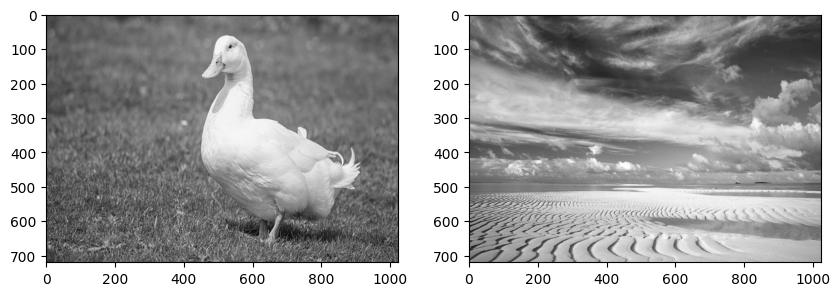

In [4]:
gray_target_img = cv2.cvtColor(img_blue_sky, cv2.COLOR_RGB2GRAY)
gray_source_img = cv2.cvtColor(img_duck, cv2.COLOR_RGB2GRAY)

# Show the images
plot_gray_subimages([gray_source_img, gray_target_img])

1 Select a grayscale image (25 points)

Mark out a region R using a polygon (you can use functions like matplotlib.path and cv2.fillpolly)
(5 points). Remove the selected region and fill it in using Equation (2) in the paper (10 points).

In [5]:
class PoissonInterpolate():
    def __init__(self, source_img, target_img):
        self.source_img = source_img
        self.target_img = target_img

    def get_mask_R(self, points, image):
        '''
        Args:
        points: boundary points of region R (array)
        image: An image array

        Return:
        mask_R: binary image with R equal to 1
        mask_R_boundary: binary image with boundary of R equal to 1
        mask_R_inside: binary image with inside of R equal to 1
        '''
        # To get the same results, fill the image with 0
        mask_R = np.zeros(image.shape)

        # mark out the region R
        cv2.fillPoly(mask_R, [points], 1)
        mask_R = mask_R.astype(np.uint8)
        
        # find boundary of region R
        contours, _ = cv2.findContours(mask_R, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        mask_R_boundary = np.zeros(mask_R.shape)
        cv2.drawContours(mask_R_boundary, contours, -1, 1)
        
        # area inside R
        mask_R_inside = mask_R - mask_R_boundary
        return mask_R, mask_R_boundary, mask_R_inside

    def get_indices(self, binary_img):
        '''
        Args:
        binary_img: an binary image

        Return: 
        Indices of binary_img equal to 1
        '''
        return np.argwhere(binary_img == 1).flatten()

    def laplacian_mat(self, mask_R, mask_R_boundary, mask_R_inside):
        
        mask_flat, mask_inside_flat, mask_bound_flat = mask_R.flatten(), mask_R_inside.flatten(), mask_R_boundary.flatten()

        # Get indices of R, inside of R and boundary of R relative to the whole image
        self.idx_R = self.get_indices(mask_flat)
        self.idx_inside_R = self.get_indices(mask_inside_flat)
        self.idx_boundary_R = self.get_indices(mask_bound_flat)

        # Get indices of inside of R and boundary of R relative to R
        self.inside_pos = np.searchsorted(self.idx_R, self.idx_inside_R)
        self.boundary_pos = np.searchsorted(self.idx_R, self.idx_boundary_R)

        size = len(self.idx_R) # size of the region
        width = self.target_img.shape[1] # width of the whole image

        # Get indices of neighbour of inner part of R relative to R
        neighbour_left_pos = np.searchsorted(self.idx_R, self.idx_inside_R - 1)
        neighbour_right_pos = np.searchsorted(self.idx_R, self.idx_inside_R + 1)
        neighbour_top_pos = np.searchsorted(self.idx_R, self.idx_inside_R - width)
        neighbour_bottom_pos = np.searchsorted(self.idx_R, self.idx_inside_R + width)

        # Creating the sparse matrix A which has a same size as region R
        A = scipy.sparse.lil_matrix((size, size))
        
        # Region R excluding boundary (inner)
        A[self.inside_pos, self.inside_pos] = -4
        A[self.inside_pos, neighbour_left_pos] = 1
        A[self.inside_pos, neighbour_right_pos] = 1
        A[self.inside_pos, neighbour_top_pos] = 1
        A[self.inside_pos, neighbour_bottom_pos] = 1

        # set the value of boundary in A matrix
        A[self.boundary_pos, self.boundary_pos] = 1

        self.laplacian = A.tocsc()
        return self.laplacian


    def editing(self, points, target_points):
        '''
        Args:
        points: corner points of boundary from source image
        target points: corner points of boundary from target image

        Return:
        res: result image
        '''
        
        # get binary image with R in target image
        tar_mask_R, tar_mask_bound, tar_mask_inside = self.get_mask_R(target_points, self.target_img)
        tar_mask_flat, tar_boun_flat = tar_mask_R.flatten(), tar_mask_bound.flatten()

        # compute A -> Ax = b
        A = self.laplacian_mat(tar_mask_R, tar_mask_bound, tar_mask_inside)
        
        # compute b -> Ax = b
        target_flatten = self.target_img.reshape(-1)
        b = np.zeros(len(self.idx_R)) 
        b[self.inside_pos] = np.zeros(len(self.inside_pos)) # In the first question, gradient = 0

        # get indices of target mask R
        idx_target_bound = self.get_indices(tar_boun_flat)
        b[self.boundary_pos] = target_flatten[idx_target_bound]
        
        # compute x -> Ax = b
        x = scipy.sparse.linalg.spsolve(A, b)

        # reconstruct target image with x
        res = target_flatten.copy()
        
        res[tar_mask_flat == 1] = x
 
        res = res.reshape(self.target_img.shape)
        res = np.clip(res, 0.0, 1.0)
        return res

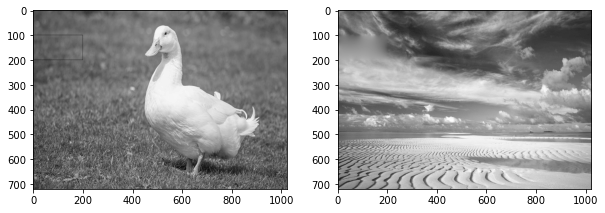

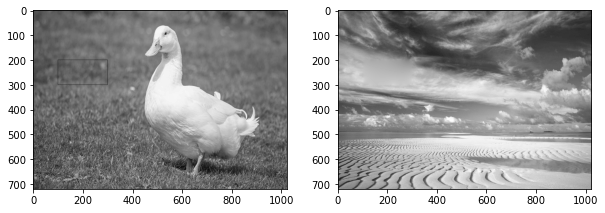

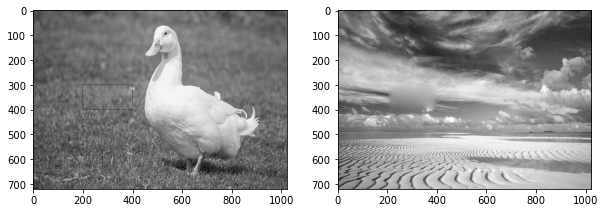

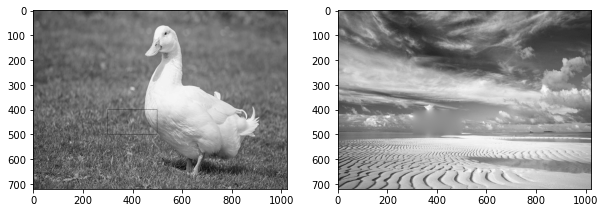

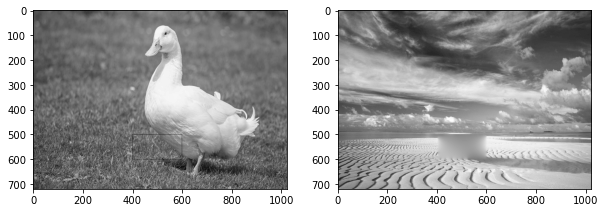

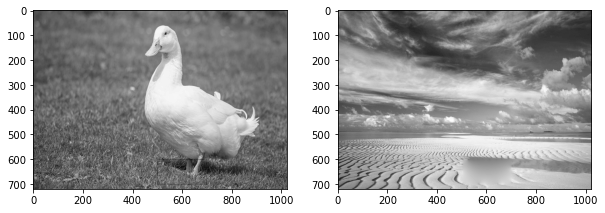

In [6]:
gray_source_img, gray_target_img = gray_source_img / 255., gray_target_img / 255.
poisson_editing = PoissonInterpolate(gray_source_img, gray_target_img)

# the position of R
points = np.array([[0, 100], [0, 200], [200, 200], [200, 100]])
offsets = np.array([0, 100, 200, 300, 400, 500]) 

# Test the method in smooth regions and also in regions with edges (high-frequency)
for i in range(len(offsets)):
    res = poisson_editing.editing(points, points+offsets[i])

    # draw the boundary of region R on source image
    _, mask_R_boundary, _ = poisson_editing.get_mask_R(points+offsets[i], gray_source_img)
    plot_gray_subimages([gray_source_img*(1-mask_R_boundary), res])

## According to the following results, it performs well in smooth regions with the region size of
## 100*100. But compared to the results in smooth regions, tests in high-frequency regions
## are more obvious.

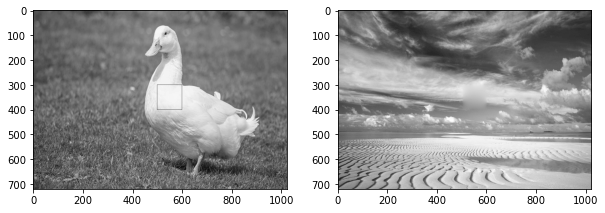

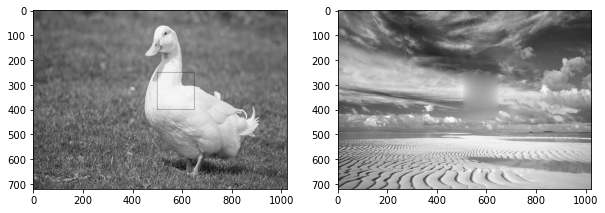

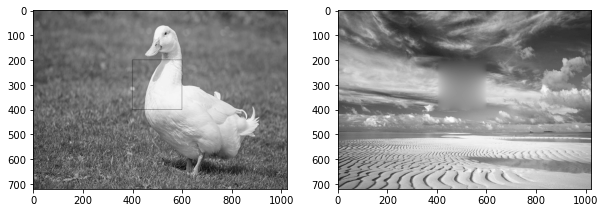

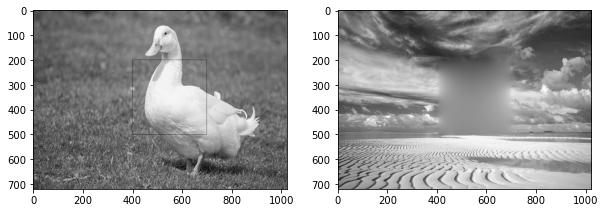

In [7]:
# Also report the behavior as the size of the selected region increases
target_points = np.array([
    [[500, 300], [500, 400], [600, 400], [600, 300]], # 100*100
    [[500, 250], [500, 400], [650, 400], [650, 250]], # 150*150
    [[400, 200], [400, 400], [600, 400], [600, 200]], # 200*200
    [[400, 200], [400, 500], [700, 500], [700, 200]] # 300*300
])
for i in range(target_points.shape[0]):
    res = poisson_editing.editing(target_points[i], target_points[i])

    _, mask_R_boundary, _ = poisson_editing.get_mask_R(target_points[i], gray_source_img)
    plot_gray_subimages([gray_source_img*(1-mask_R_boundary), res])


## The smaller the size of selected region, the better the performance.
#  The larger the size of selected region, the more pronounced the result.

2 Seamless cloning for grayscale images


(a) Importing gradients (20 points). (b) Mixing gradients (20 points).

In [6]:
class SeamlessPoissonEditing(PoissonInterpolate):
    def compute_gradient(self, img):
        # Calculate vertical and horizontal gradients of images respectively
        kernel_x = np.array([[0, 0, 0], [-1, 1, 0], [0, 0, 0]])
        kernel_y = np.array([[0, -1, 0], [0, 1, 0], [0, 0, 0]])

        gradient_x = scipy.signal.fftconvolve(img, kernel_x, 'same')
        gradient_y = scipy.signal.fftconvolve(img, kernel_y, 'same')

        return gradient_x, gradient_y
        
    # answer for question 2a
    def editing(self, points, target_points):

        # get binary images with R in source image
        mask_R, mask_R_boundary, mask_R_inside = self.get_mask_R(points, self.source_img)
        source_flatten, target_flatten = self.source_img.flatten(), self.target_img.flatten()

        # compute A -> Ax = b using source image
        A = self.laplacian_mat(mask_R, mask_R_boundary, mask_R_inside)
        
        # compute div g
        div_g = A.dot(source_flatten[self.idx_R])
        div_g_inside = div_g[self.inside_pos]
        

        # get binary images with R in target image
        tar_mask_R, tar_mask_bound, tar_mask_inside = self.get_mask_R(target_points, self.target_img)
        tar_mask_flat, tar_boun_flat = tar_mask_R.flatten(), tar_mask_bound.flatten()

        # compute A_ using target image
        A_ = self.laplacian_mat(tar_mask_R, tar_mask_bound, tar_mask_inside)

        # compute b -> Ax = b
        b = np.zeros(len(self.idx_R))
    
        # div g = div f
        b[self.inside_pos] = div_g_inside
        b[self.boundary_pos] = target_flatten[self.idx_boundary_R]
        
        # compute x -> Ax = b
        x = scipy.sparse.linalg.spsolve(A_, b)

        # reconstruct target image with x
        res = target_flatten.copy()
        res[tar_mask_flat == 1] = x

        res = res.reshape(self.target_img.shape)
        res = np.clip(res, 0.0, 1.0)
        return res
    
    # answer for question 2b
    def mixing_gradient_editing(self, points, target_points):
        
        # get binary image with R in source image
        mask_R, _, _ = self.get_mask_R(points, self.source_img)

        # get binary image with R in target image
        tar_mask_R, tar_mask_bound, tar_mask_inside = self.get_mask_R(target_points, self.target_img)
        tar_mask_flat, tar_boun_flat = tar_mask_R.flatten(), tar_mask_bound.flatten()
     

        # compute gradient of g & f (source image & target image) and their magnitude
        gradient_x_g, gradient_y_g = self.compute_gradient(self.source_img) * mask_R
        gradient_g = np.sqrt(gradient_x_g ** 2 + gradient_y_g ** 2)

        gradient_x_f, gradient_y_f = self.compute_gradient(self.target_img) * tar_mask_R
        gradient_f = np.sqrt(gradient_x_f ** 2 + gradient_y_f ** 2)


        # compare gradients in the g and f and choose the larger one
        gradient_x = np.where(gradient_g > gradient_f, gradient_x_g, gradient_x_f)
        gradient_y = np.where(gradient_g > gradient_f, gradient_y_g, gradient_y_f)

        # gradient_x, gradient_y = gradient_x[self.idx_R], gradient_y[self.idx_R]
        target_flatten = self.target_img.flatten()

        # div x
        gradient_x_square, _ = self.compute_gradient(gradient_x)

        # div y
        _, gradient_y_square = self.compute_gradient(gradient_y)
        
        # mixed gradient = div x + div y
        mixed_gradient = (gradient_x_square + gradient_y_square).flatten() 

        # compute A_ using target image
        A_ = self.laplacian_mat(tar_mask_R, tar_mask_bound, tar_mask_inside)

        # compute b -> Ax = b
        b = np.zeros(len(self.idx_R))
        
        b[self.inside_pos] = mixed_gradient[self.idx_inside_R]
        b[self.boundary_pos] = target_flatten[self.idx_boundary_R]
        
        # compute x -> Ax = b
        x = scipy.sparse.linalg.spsolve(A_, b)

        # reconstruct target image with x
        res = target_flatten.copy()

        res[tar_mask_flat == 1] = x 
        res = res.reshape(self.target_img.shape)
        res = np.clip(res, 0, 1)

        return res

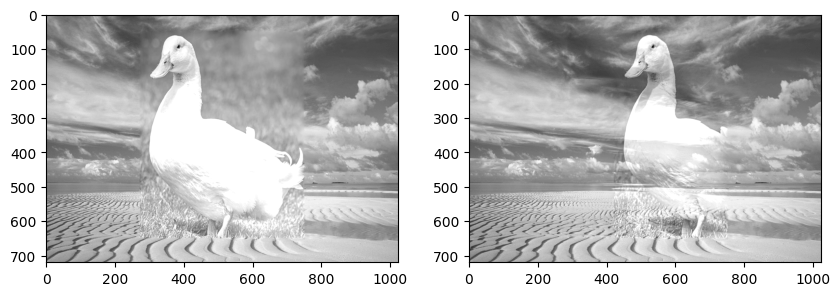

In [7]:
gray_target_img = cv2.cvtColor(img_blue_sky, cv2.COLOR_RGB2GRAY)
gray_source_img = cv2.cvtColor(img_duck, cv2.COLOR_RGB2GRAY)

gray_source_img, gray_target_img = gray_source_img / 255., gray_target_img / 255.

seamless_poisson_editing = SeamlessPoissonEditing(gray_source_img, gray_target_img)

points = np.array([[420, 650], [900, 650], [900, 50], [420, 50]])
offsets = np.array([-150, 0])

seamless_res = seamless_poisson_editing.editing(points, points+offsets)
mixing_gradient_res = seamless_poisson_editing.mixing_gradient_editing(points, points+offsets)
plot_gray_subimages([seamless_res, mixing_gradient_res])

## The first method results in some blurring of boundaries, but we can still see the boundaries.
## In the mixing gradients method, the image blends better with the background, 
# and the border can hardly be seen, but some values of intensity from source image are unobvious.

3 Seamless cloning for color images (10 points)

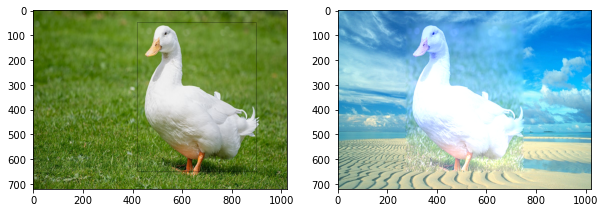

In [10]:
source_img = img_duck / 255.
target_img = img_blue_sky / 255.
output = np.zeros((target_img.shape))


points = np.array([[420, 650], [900, 650], [900, 50], [420, 50]])
offsets = np.array([-150, 0])

# Process RGB channels respectively
for i in range(3):
    seamless_possion_editing = SeamlessPoissonEditing(source_img[..., i], target_img[..., i])
    output[..., i] = seamless_possion_editing.editing(points, points+offsets) # task 2a

# draw the boundary of region R on source image 
_, mask_R_boundary, _ = poisson_editing.get_mask_R(points, source_img[..., 0])
plot_subimages([source_img*(1-mask_R_boundary)[..., np.newaxis], output]) 

4 Selection editing effects

a) Texture flattening

In [11]:
class TextureFlattening(SeamlessPoissonEditing):
    def edge_detector(self, img):
        img = img[..., 0] * 255.

        # edge detection
        sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        mask_edges = scipy.signal.fftconvolve(img, sobel_x, 'same')
           
        # binarize the image
        mask_edges = np.where(mask_edges >= -20, 1., 0.)
        plt.imshow(mask_edges, 'binary')
        return mask_edges

    def texture_flattening(self, points, target_points):
        blur_img = cv2.GaussianBlur(self.source_img, (3, 3), 1)
        mask_edges = self.edge_detector(blur_img)

        output = self.target_img.copy()
        
        for i in range(self.target_img.shape[2]):
            # get binary image with R in source image
            mask_R, mask_R_boundary, mask_R_inside = self.get_mask_R(points, self.source_img[..., i])
            mask_R_flat = mask_R.flatten()
     

            # compute gradient of g (source image)
            gradient_x_g, gradient_y_g = self.compute_gradient(self.source_img[..., i]) * mask_R

            # retain the part that contains the edges
            mask_edges_R = mask_edges * mask_R
            gradient_x = gradient_x_g * mask_edges_R
            gradient_y = gradient_y_g * mask_edges_R

            target_flatten = self.target_img[..., i].flatten()

            # div x
            gradient_x_square, _ = self.compute_gradient(gradient_x)

            # div y
            _, gradient_y_square = self.compute_gradient(gradient_y)

            # left gradient = div x + div y
            left_gradient = (gradient_x_square + gradient_y_square).flatten()


            # compute A using source image
            A = self.laplacian_mat(mask_R, mask_R_boundary, mask_R_inside)

            # compute b -> Ax = b
            b = np.zeros(len(self.idx_R))

            b[self.inside_pos] = left_gradient[self.idx_inside_R]
            b[self.boundary_pos] = target_flatten[self.idx_boundary_R]

            # compute x -> Ax = b
            x = scipy.sparse.linalg.spsolve(A, b)

            # reconstruct target image with x
            res = target_flatten.copy()

            res[mask_R_flat == 1] = x 
            res = res.reshape(self.target_img[..., i].shape)
            res = np.clip(res, 0, 1)
            output[..., i] = res

        return output

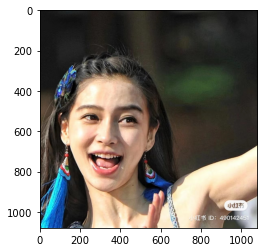

In [12]:
# load image
img_ab = plt.imread('./data/ab.jpg')
plt.imshow(img_ab)

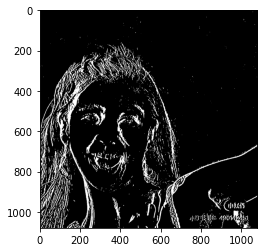

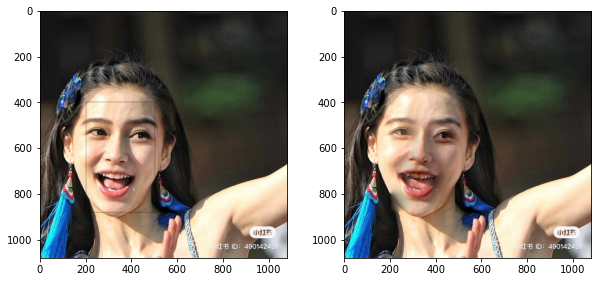

In [13]:
source_img = img_ab / 255.
points = np.array([[200, 880], [500, 880], [500, 400], [200, 400]])

# Applying texture flattening on the ab
texture_flattening = TextureFlattening(source_img.copy(), source_img.copy())
output = texture_flattening.texture_flattening(points, points)

_, mask_R_boundary, _ = texture_flattening.get_mask_R(points, source_img[..., 0])
plot_subimages([source_img*(1-mask_R_boundary)[..., np.newaxis], output]) 